This is my personal implementation of the Vision Transformer (https://arxiv.org/pdf/2010.11929v2.pdf). 
This approach uses the original Transformer architecture but applies it to images.

I documented alfl of my learning process in commits on the 'ViT_dev' branch, and then just merged the final result into 'main' once I was done. If you'd like
to see my struggles, please feel free to checkout ViT_dev and enjoy! 

Import packages

In [4]:
import math
import einops
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor

Import the test image from ImageNet dataset.

(500, 375)


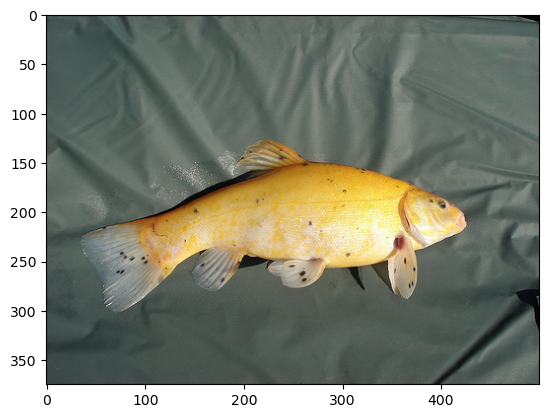

In [5]:
test_input = Image.open('/home/achalhoub/dev/research_implementations/ViT_pt/input/imagenet_sample.jpeg')
fig = plt.figure()
plt.imshow(test_input)
print(test_input.size)

Set device and hyperparameters of network.

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

patch_size = 16         # Patch size (P)
latent_vector = 768    # Latent vector (D). ViT-Large uses 1024
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Large uses 16 heads
batch_size = 16
num_encoders = 24       # ViT-Large uses 24 encoder layers
dropout = 0.1
num_classes = 1000      # Number of classes in the dataset used

cpu


Implement Input Embedding class. This class performs all the steps needed before the data goes into the 'Transformer Encoder' block. This includes splitting input images into patches, performing the linear projections of the patches, pre-pending a [class] token and adding a position embedding to the linear projection. The output of this class is fed into the Encoder.

In [13]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, latent_vector=latent_vector):
        super(InputEmbedding, self).__init__()
        self.latent_vector = latent_vector
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_vector)

        # Random initialization of of [class] token that
        # is prepended to the linear projection
        self.class_token = torch.rand(1, self.latent_vector).unsqueeze(0)

        # Embedding layer for position encodings
        self.embeddingLayer = nn.Embedding(self.latent_vector+1, self.latent_vector)


    def forward(self, input):
        image_transform = Compose([Resize((256, 256)), ToTensor()])
        transformed_image = image_transform(input).unsqueeze(0)
        patches = einops.rearrange(transformed_image, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches)
        
        # Prepend the [class] token to the original linear projection
        new_vector = torch.cat((self.class_token, linear_projection), dim=1)

        # Create a positions vector to create the position encodings
        positions_vector = torch.arange(0, new_vector.shape[1]).expand(new_vector.shape[0], new_vector.shape[1])

        # Add the positional encodings to the linear vector (with the class token)
        return new_vector + self.embeddingLayer(positions_vector)

In [14]:
test_embedding = InputEmbedding().forward(test_input)
print('Embedded Patches dimension: ', test_embedding.size())

Embedded Patches dimension:  torch.Size([1, 257, 768])


Now implement the Encoder block.

In [31]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_vector=latent_vector, num_heads=num_heads, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_vector = latent_vector
        self.num_heads = num_heads
        self.dropout = dropout

        # First Normalization layer
        self.firstNorm = nn.LayerNorm(self.latent_vector)       
        
        # Multi-Head Attention layer
        self.multihead = nn.MultiheadAttention(
            self.latent_vector, self.num_heads, dropout=self.dropout)              
        
        # Second Normalization layer
        self.secondNorm = nn.LayerNorm(self.latent_vector)      

        #self.dropoutLayer = nn.Dropout(p=self.dropout)

        # MLP layer. I use the same configuration as that used 
        # in the original Transformer implementation. The ViT paper mentions
        # that all layers have a constant D dimension (latent vector size), so
        # I'm not sure if they implement expansion here or not.
        self.feedForward = nn.Sequential(
            nn.Linear(self.latent_vector, self.latent_vector*4),
            nn.GELU(),
            nn.Linear(self.latent_vector*4, self.latent_vector)
        )

    def forward(self, embedded_patches):

        # First sublayer: Norm + Multi-Head Attention + residual connection.
        # We take the first element ([0]) of the returned output from nn.MultiheadAttention()
        # because this module returns 'Tuple[attention_output, attention_output_weights]'. 
        # Refer to here for more info: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
        firstNorm_out = self.firstNorm(embedded_patches)
        attention_output = self.multihead.forward(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        first_added_output = attention_output + embedded_patches

        #attention_output = self.dropoutLayer(attention_output)

        # Second sublayer: Norm + MLP (Feed forward)
        secondNorm_out = self.secondNorm(first_added_output)
        ff_output = self.feedForward(secondNorm_out)

        #ff_output = self.dropoutLayer(ff_output)

        # Return the output of the second residual connection
        return ff_output + first_added_output

Test progress so far with sample image.

In [32]:
encBlock = EncoderBlock(latent_vector, num_heads, dropout)
output = encBlock.forward(test_embedding)
print('Output type: ', type(output))
print('Output size: ', output.size())

Output type:  <class 'torch.Tensor'>
Output size:  torch.Size([1, 257, 768])


Output MLP block.

In [69]:
class Transformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_vector=latent_vector, device=device, num_classes=num_classes):
        super(Transformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_vector = latent_vector
        self.device = device
        self.num_classes = num_classes

        self.embedding = InputEmbedding().to(self.device)
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        # MLP at the classification head has 'one hidden layer at pre-training time'.
        # I'll have to double-check if what I've implemented is correct.
        # Also, is Softmax used?
        self.MLP = nn.Sequential(
            nn.Linear(self.latent_vector, self.latent_vector),
            nn.Linear(self.latent_vector, self.num_classes)
        )
        #self.softmax = nn.Softmax()

    def forward(self, test_input):

        enc_output = self.embedding.forward(test_input)

        # Final output 'enc_output' of this loop will be both the key and value
        # that will be taken as input to the second sub-layer of the decoder
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)
        print('enc_output shape: ', enc_output.size())

        # Return only the vector of the first token, which is the [class]
        # token that's used to classify.
        return self.MLP(enc_output)[0][0]

In [70]:
transformer = Transformer(num_encoders, latent_vector, device, num_classes)
tr_output = transformer.forward(test_input)
print(tr_output.shape)

enc_output shape:  torch.Size([1, 257, 768])
torch.Size([1000])


In [71]:
print(type(tr_output))
print(tr_output.size())
print(tr_output.shape)

<class 'torch.Tensor'>
torch.Size([1000])
torch.Size([1000])
